## Семинар 15: различные имплементации градиентного бустинга

* XGboost + подбор гиперпараметров
* CatBoost + SHAP
* LightGBM

!["История"](bst.png)

## 1. XGboost + подбор гиперпараметров

Код по xgboost основан на статье https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

Основные особенности xgboost:
* базовый алгоритм приближает направление, посчитанное с учетом второй производной функции потерь

* функционал регуляризуется – добавляются штрафы за количество листьев и за норму коэффициентов

* при построении дерева используется критерий информативности, зависящий от оптимального вектора сдвига

* критерий останова при обучении дерева также зависит от оптимального сдвига

Почитать подробнее тут: https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture10-ensembles.pdf

In [ ]:
import pandas as pd
import os
import numpy as np
from matplotlib import pylab as plot
%pylab inline

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plot']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Будем решать задачу классификации: по различным характеристикам клиента попытаемся определить, выплатит клиент долг или нет.

In [ ]:
X_train = pd.read_csv('train_small.csv')
X_test = pd.read_csv('test_small.csv')
len(X_train), len(X_test)

(8410, 10443)

# Новый раздел

In [ ]:
X_train.head()

,Existing_EMI,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,Age,EMI_Loan_Submitted_Missing,Interest_Rate_Missing,Loan_Amount_Submitted_Missing,Loan_Tenure_Submitted_Missing,Processing_Fee_Missing,Device_Type_0,Device_Type_1,Filled_Form_0,Filled_Form_1,Gender_0,Gender_1,Var1_0,Var1_1,Var1_2,Var1_3,Var1_4,Var1_5,Var1_6,Var1_7,Var1_8,Var1_9,Var1_10,Var1_11,Var1_12,Var1_13,Var1_14,Var1_15,Var1_16,Var1_17,Var1_18,Var2_0,Var2_1,Var2_2,Var2_3,Var2_4,Var2_5,Var2_6,Mobile_Verified_0,Mobile_Verified_1,Source_0,Source_1,Source_2,Disbursed,ID
0,0.0,250000.0,5.0,23200,2,3,28,1,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0.0,8161.0
1,0.0,0.0,0.0,25000,0,0,33,1,1,1,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0.0,77530.0
2,0.0,0.0,0.0,95000,3,7,39,1,1,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0.0,80633.0
3,0.0,0.0,0.0,29880,5,3,28,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0.0,45059.0
4,4500.0,100000.0,3.0,30000,5,10,26,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0.0,54857.0


Для того, чтобы бустинг показал хорошее качество и не переобучился, необходимо аккуратно подобрать его гиперпараметры. 

Алгоритм подбора гиперпараметров следующий:

* Выбираем относительно большую learning_rate ($ \eta \in [0.05, 0.3]$), подбираем оптимальное число деревьев для выбранного $ \eta $

* Настраиваем параметры деревьев, начиная с самых значимых (max_depth, min_child_weight, gamma, subsample, colsample_bytree)

* Настраиваем регуляризации ($ \lambda, \alpha $)

* Уменьшаем learning_rate, пропорционально увеличиваем число деревьев

In [ ]:
xgb1 = XGBClassifier(
        learning_rate=0.1,
        n_estimators=150,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)

In [ ]:
target='Disbursed'
IDcol = 'ID'

In [ ]:
X_train['Disbursed'].value_counts(), len(X_train)

(0.0    8286
 1.0     124
 Name: Disbursed, dtype: int64, 8410)

Создадим функцию для моделирования и кросс-валидации

Эта функция делает следующее:
1. обучает модель
2. вычисляет accuracy на тренировочной выборке
3. вычисляет AUC на тренировочной выборке
4. вычисляет AUC на тестовой выборке
5. обновляет n_estimators с помощью встроенной в пакет xgboost функции cv
6. строит диаграмму Feature Importance 

In [ ]:
from sklearn import metrics

def modelfit(alg, dtrain, dtest, predictors, useTrainCV=True, cv_folds=5, \
             early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
    
    #Predict on testing data:
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    print('AUC Score (Test): %f' % metrics.roc_auc_score(dtest['Disbursed'], dtest['predprob']))
                
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

Начинаем последовательный подбор параметров при большом learning_rate


Model Report
Accuracy : 0.9853
AUC Score (Train): 0.864846
AUC Score (Test): 0.831369


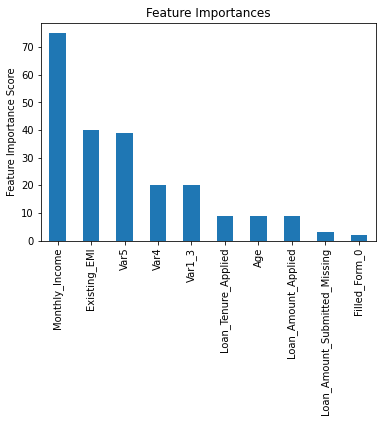

In [ ]:
predictors = [x for x in X_train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate=0.1,
        n_estimators=150,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, X_train, X_test, predictors)

Перебираем max_depth и min_child_weight по сетке.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=150,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_train[predictors],X_train[target])

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=150, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score

In [ ]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 5}, 0.8000934749654146)

Уточняем предсказание

In [ ]:
param_test2 = {
    'max_depth':[2,3,4],
    'min_child_weight':[2,3,4]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=150, 
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train[predictors],X_train[target])

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=150, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=1, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'max_depth': [2, 3, 4], 'min_child_weight': [2, 3, 4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', ver

In [ ]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 2, 'min_child_weight': 3}, 0.8140399423410909)

Зафиксируем найденный max_depth и подберем min_child_weight

In [ ]:
param_test2b = {
    'min_child_weight':[5,6,7]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=150, max_depth=4,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(X_train[predictors],X_train[target])

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=4, min_child_weight=1,
                                     missing=None, n_estimators=150, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=1, verbosity=1),
             iid=False, n_jobs=4, param_grid={'min_child_weight': [5, 6, 7]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [ ]:
gsearch2b.best_params_, gsearch2b.best_score_

({'min_child_weight': 7}, 0.7988766731239014)

Мы подобрали max_depth и min_child_weight - дальше будем использовать подобранные значения параметров. Подберите по сетке параметр gamma на отрезке от 0 до 1.

In [ ]:
param_test3 = {
    'gamma': np.arange(0, 1.1, 0.1)
}
gsearch3b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=150, max_depth=3, min_child_weight = 6,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3b.fit(X_train[predictors],X_train[target])

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=6,
                                     missing=None, n_estimators=150, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=1, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'gamma': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scor

In [ ]:
gsearch3b.best_params_, gsearch3b.best_score_

({'gamma': 1.0}, 0.8125500123878933)

Установите в качестве параметров алгоритма подобранные max_depth, min_child_weight и gamma и посмотрите как изменилось качество.


Model Report
Accuracy : 0.9853
AUC Score (Train): 0.871675
AUC Score (Test): 0.831954


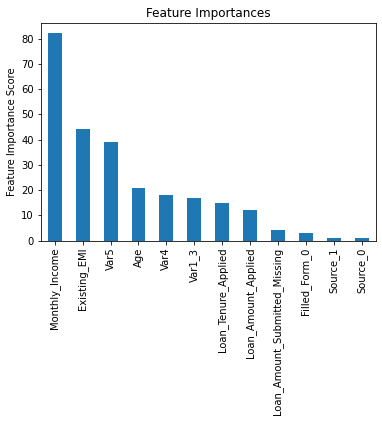

In [ ]:
predictors = [x for x in X_train.columns if x not in [target, IDcol]]
xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=150,
        max_depth=3,
        min_child_weight=6,
        gamma = 0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb2, X_train, X_test, predictors)

Подберите по сетке параметры subsample и colsample_bytree. Используйте значения этих параметров: [0.6,0.7,0.8,0.9,1.]

In [ ]:
param_test4 = {
    'subsample': [i/10 for i in range(6, 11)],
    'colsample_bytree': [i/10 for i in range(6, 11)],
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=150, max_depth=3, min_child_weight = 6,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train[predictors],X_train[target])


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=6,
                                     missing=None, n_estimators=150, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=1, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
                         'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
             pre_dispatch='2*n_jobs', refit=True, retu

Подберите параметр регуляризации reg_alpha. Попробуйте [1e-5, 1e-2, 0.1, 1, 100]

In [ ]:
param_test5 = {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=150, max_depth=3, min_child_weight = 6,
                                                  subsample = 0.6, colsample_bytree = 0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train[predictors],X_train[target])

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=6,
                                     missing=None, n_estimators=150, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.6, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

Запустите обучение и предсказание на найденных параметрах и посмотрите на качество.

In [ ]:
xgb3 = XGBClassifier(
        learning_rate=0.1,     
        n_estimators=150,   
        max_depth=...,
        min_child_weight=...,
        gamma=...,
        subsample=...,
        colsample_bytree=...,
        reg_alpha=...,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb3, X_train, X_test, predictors)

Уменьшите learning_rate до 0.01 и пропорционально увеличьте число деревьев. Все подобранные параметры остаются такими же. Обучите модель и сделайте предсказание. Посмотрите на качество.

In [ ]:
#Your code here
xgb3 = XGBClassifier(
        learning_rate=0.01,
        n_estimators=1500,
        max_depth=...,
        min_child_weight=...,
        gamma=...,
        subsample=...,
        colsample_bytree=...,
        reg_alpha=...,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb3, X_train, X_test, predictors)

## 2. CatBoost

Оригинальный ноутбук здесь: https://github.com/catboost/tutorials/blob/master/classification/classification_tutorial.ipynb

Особенности катбуста:

* используются симметричные деревья решений

* для кодирования категориальных признаков используется большой набор методов

* динамический бустинг 

Благодаря использованию симметричных деревьев и динамическому бустингу катбуст гораздо более устойчив к переобучению, чем другие имплементации градиентного бустинга. Поэтому он показывает хорошее качество даже при дефолтных параметрах.

Посмотреть видео про катбуст: https://yandex.ru/video/preview/?filmId=10919886479285152550&from=tabbar&text=catboost+анна+вероника

Устанавливаем библиотеки

In [4]:
!pip install catboost

     |████████████████████████████████| 67.4 MB 29 kB/s 


In [ ]:
#!pip install --user --upgrade catboost
#!pip install --user --upgrade ipywidgets
#!pip install shap
#!pip install sklearn
#!pip install --upgrade numpy
#!jupyter nbextension enable --py widgetsnbextension

import catboost

In [5]:
from matplotlib import pylab as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [6]:
np.set_printoptions(precision=4)
import catboost
from catboost import *
from catboost import datasets

Считываем данные. Данные содержат только категориальные признаки, причем с большим количеством категорий. Признаки - закодированные характеристики сотрудника и некоторого ресурса, целевая переменная - есть ли у сотрудника доступ к ресурсу.

In [7]:
(train_df, test_df) = catboost.datasets.amazon()

In [8]:
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


Готовим данные

In [9]:
y = train_df.ACTION
X = train_df.drop('ACTION', axis=1)

Создаем список категориальных фичей

In [10]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


Смотрим на соотношение классов

In [11]:
print('Labels: {}'.format(set(y)))
print('Zero count = {}, One count = {}'.format(len(y) - sum(y), sum(y)))

Labels: {0, 1}
Zero count = 1897, One count = 30872


Способы создать Pool - объект, содержащий матрицу объект-признак X, вектор ответов, список номеров колонок с категориальными признаками.

In [12]:
pool1 = Pool(data=X, label=y, cat_features=cat_features)

pool2 = Pool(data=X, cat_features=cat_features)

# Fastest way to create a Pool is to create it from numpy matrix.
# This way should be used if you want fast predictions
# or fastest way to load the data in python.

X_prepared = X.values.astype(str).astype(object)
# For FeaturesData class categorial features must have type str

pool3 = Pool(
    data=FeaturesData(
        cat_feature_data=X_prepared,
        cat_feature_names=list(X)
    ),
    label=y.values
)

print('Dataset shape')
print('dataset 1:' + str(pool1.shape) +
      '\ndataset 2:' + str(pool2.shape) +
      '\ndataset 3: ' + str(pool3.shape))

print('\n')
print('Column names')
print('dataset 1:')
print(pool1.get_feature_names()) 
print('\ndataset 2:')
print(pool2.get_feature_names())
print('\ndataset 3:')
print(pool3.get_feature_names())

Dataset shape
dataset 1:(32769, 9)
dataset 2:(32769, 9)
dataset 3: (32769, 9)


Column names
dataset 1:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 2:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 3:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']


Разбиваем данные на train и validation

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=42)

Выбираем функцию потерь

Для бинарной классификации можем использовать:

* `Logloss`

* `CrossEntropy`

In [14]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
    # loss_function='CrossEntropy'
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'iterations': 5, 'learning_rate': 0.1}


Печать результатов

In [15]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=15,
#     verbose=5,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

Learning rate set to 0.441257
0:	learn: 0.4227692	test: 0.4210990	best: 0.4210990 (0)	total: 18.4ms	remaining: 258ms
1:	learn: 0.3156595	test: 0.3124516	best: 0.3124516 (1)	total: 39ms	remaining: 253ms
2:	learn: 0.2629962	test: 0.2592571	best: 0.2592571 (2)	total: 57.1ms	remaining: 228ms
3:	learn: 0.2318854	test: 0.2270579	best: 0.2270579 (3)	total: 76.7ms	remaining: 211ms
4:	learn: 0.2074867	test: 0.2005202	best: 0.2005202 (4)	total: 94.2ms	remaining: 188ms
5:	learn: 0.1958334	test: 0.1865581	best: 0.1865581 (5)	total: 110ms	remaining: 166ms
6:	learn: 0.1886256	test: 0.1773071	best: 0.1773071 (6)	total: 127ms	remaining: 145ms
7:	learn: 0.1835420	test: 0.1709810	best: 0.1709810 (7)	total: 144ms	remaining: 126ms
8:	learn: 0.1821405	test: 0.1688308	best: 0.1688308 (8)	total: 160ms	remaining: 107ms
9:	learn: 0.1785695	test: 0.1645358	best: 0.1645358 (9)	total: 184ms	remaining: 92.2ms
10:	learn: 0.1767659	test: 0.1625349	best: 0.1625349 (10)	total: 206ms	remaining: 75ms
11:	learn: 0.175310

Визуализация метрик

In [16]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=50,
    random_seed=63,
    learning_rate=0.5,
    custom_loss=['AUC', 'Accuracy']
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Сравнение моделей

In [17]:
model1 = CatBoostClassifier(
    learning_rate=0.7,
    iterations=100,
    random_seed=0,
    train_dir='learing_rate_0.7'
)

model2 = CatBoostClassifier(
    learning_rate=0.01,
    iterations=100,
    random_seed=0,
    train_dir='learing_rate_0.01'
)
model1.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
model2.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)

In [18]:
from catboost import MetricVisualizer
MetricVisualizer(['learing_rate_0.01', 'learing_rate_0.7']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Оптимальное количество деревьев

In [19]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
#     use_best_model=False
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [20]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 92


Кросс-валидация

In [21]:
from catboost import cv

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 80
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.5

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [22]:
cv_data.head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.302656,0.003539,0.302803,0.003277,0.527207,0.024999
1,1,0.229539,0.010203,0.230381,0.003876,0.623304,0.052296
2,2,0.192070,0.007484,0.197596,0.002449,0.785451,0.022382
3,3,0.179042,0.008344,0.187064,0.001322,0.812158,0.009366
4,4,0.172471,0.006871,0.181871,0.001984,0.826281,0.010307


In [23]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, not stratified: 0.1583±0.0081 on step 54


Детектор переобучения

In [24]:
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [25]:
print(model_with_early_stop.tree_count_)

21


In [26]:
model_with_early_stop = CatBoostClassifier(
    eval_metric='AUC',
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [27]:
print(model_with_early_stop.tree_count_)

52


Вычисление метрик качества и выбор порога принятия решения

In [28]:
model = CatBoostClassifier(
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

![](https://habrastorage.org/webt/y4/1q/yq/y41qyqfm9mcerp2ziys48phpjia.png)

In [29]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = Pool(X_validation, y_validation, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

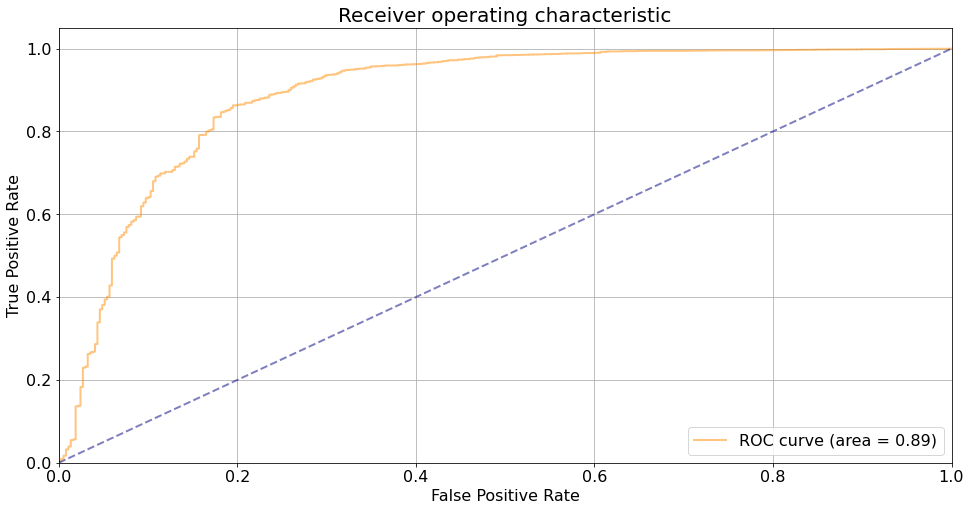

In [30]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [31]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

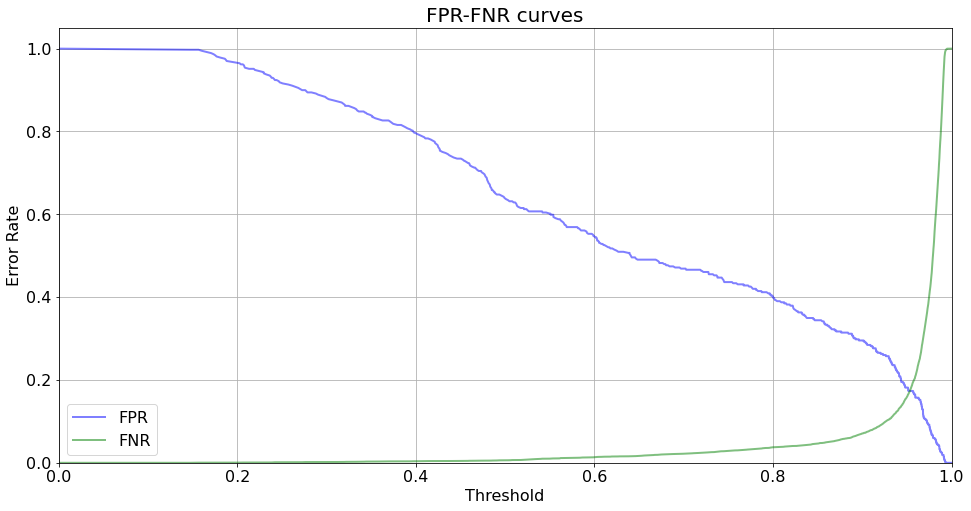

In [32]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

In [33]:
from catboost.utils import select_threshold

print(select_threshold(model=model, data=eval_pool, FNR=0.01))
print(select_threshold(model=model, data=eval_pool, FPR=0.01))

0.5419378571539639
0.9918541332871926


Получение предсказаний

In [34]:
print(model.predict_proba(data=X_validation))

TypeError: ignored

In [36]:
print(model.predict(data=X_validation))

[1 1 1 ... 1 1 1]


Последовательные предсказания

In [37]:
predictions_gen = model.staged_predict_proba(
    data=X_validation,
    ntree_start=0, 
    ntree_end=5, 
    eval_period=1
)
try:
    for iteration, predictions in enumerate(predictions_gen):
        print('Iteration ' + str(iteration) + ', predictions:')
        print(predictions)
except Exception:
    pass

Iteration 0, predictions:
[[0.4794 0.5206]
 [0.4794 0.5206]
 [0.4794 0.5206]
 ...
 [0.4794 0.5206]
 [0.4794 0.5206]
 [0.4794 0.5206]]
Iteration 1, predictions:
[[0.4588 0.5412]
 [0.4588 0.5412]
 [0.4588 0.5412]
 ...
 [0.4588 0.5412]
 [0.4588 0.5412]
 [0.4588 0.5412]]
Iteration 2, predictions:
[[0.4397 0.5603]
 [0.4397 0.5603]
 [0.4397 0.5603]
 ...
 [0.4397 0.5603]
 [0.4397 0.5603]
 [0.4397 0.5603]]
Iteration 3, predictions:
[[0.4184 0.5816]
 [0.4184 0.5816]
 [0.4259 0.5741]
 ...
 [0.4184 0.5816]
 [0.4184 0.5816]
 [0.4184 0.5816]]
Iteration 4, predictions:
[[0.4004 0.5996]
 [0.4004 0.5996]
 [0.4078 0.5922]
 ...
 [0.4004 0.5996]
 [0.4004 0.5996]
 [0.4004 0.5996]]


Важность признаков

In [38]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,RESOURCE,22.389723
1,MGR_ID,22.145932
2,ROLE_DEPTNAME,17.668522
3,ROLE_FAMILY_DESC,8.298617
4,ROLE_CODE,8.199040
5,ROLE_ROLLUP_2,8.010932
6,ROLE_TITLE,7.213665
7,ROLE_FAMILY,3.088934
8,ROLE_ROLLUP_1,2.984636


### Shap values 

Классические способы измерения важности признаков обладают существенным недостатком: непонятно, как именно каждый признак влияет на предсказание модели. Shap values (значения Шэпли) - способ измерения важности признаков, исправляющий этот недостаток.

Подробнее читайте тут: https://habr.com/ru/post/428213/

In [40]:
!pip install shap

     |████████████████████████████████| 356 kB 4.1 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491637 sha256=2fae7a98523f8c1a0b018352875f3064e25fd51dd7d44cdeff4ab5194f21e91a
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [41]:
import shap

shap_values = model.get_feature_importance(pool1, type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

print(shap_values.shape)

(32769, 9)


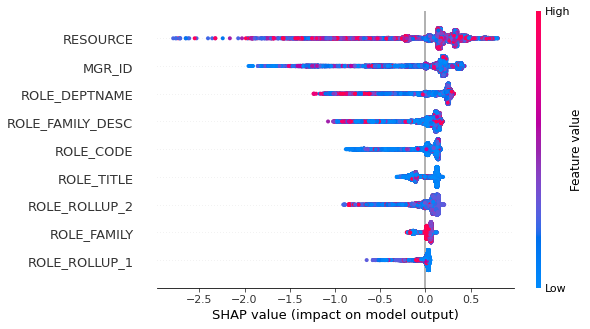

In [42]:
shap.summary_plot(shap_values, X)

Shap-values для конкретного объекта.

In [43]:
shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X.iloc[3,:])

Сохранение модели

In [44]:
my_best_model = CatBoostClassifier(iterations=10)
my_best_model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
my_best_model.save_model('catboost_model.bin')
my_best_model.save_model('catboost_model.json', format='json')

In [45]:
my_best_model.load_model('catboost_model.bin')
print(my_best_model.get_params())
print(my_best_model.random_seed_)

{'iterations': 10, 'loss_function': 'Logloss', 'verbose': 0}
0


Подбор гиперпараметров

In [46]:
cat = CatBoostClassifier(n_estimators=50)

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10]}
#        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = cat.grid_search(grid, X=X_train, y=y_train, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6563004	test: 0.6566072	best: 0.6566072 (0)	total: 11.3ms	remaining: 552ms
1:	learn: 0.6227519	test: 0.6234014	best: 0.6234014 (1)	total: 22.6ms	remaining: 541ms
2:	learn: 0.5916195	test: 0.5927244	best: 0.5927244 (2)	total: 34ms	remaining: 532ms
3:	learn: 0.5627225	test: 0.5641488	best: 0.5641488 (3)	total: 45.3ms	remaining: 521ms
4:	learn: 0.5360900	test: 0.5378118	best: 0.5378118 (4)	total: 56.7ms	remaining: 510ms
5:	learn: 0.5116507	test: 0.5137107	best: 0.5137107 (5)	total: 71.6ms	remaining: 525ms
6:	learn: 0.4891057	test: 0.4914464	best: 0.4914464 (6)	total: 82.8ms	remaining: 509ms
7:	learn: 0.4683800	test: 0.4710067	best: 0.4710067 (7)	total: 93.9ms	remaining: 493ms
8:	learn: 0.4494524	test: 0.4523627	best: 0.4523627 (8)	total: 105ms	remaining: 478ms
9:	learn: 0.4316802	test: 0.4348204	best: 0.4348204 (9)	total: 117ms	remaining: 466ms
10:	learn: 0.4155498	test: 0.4189671	best: 0.4189671 (10)	total: 128ms	remaining: 454ms
11:	learn: 0.4007172	test: 0.4044185	best: 0.4

In [47]:
grid_search_result['params']

{'depth': 10, 'learning_rate': 0.1}

Визуализация деревьев

In [48]:
cat.plot_tree(tree_idx=0)

Хорошее описание гиперпараметров катбуста: https://habr.com/ru/company/otus/blog/527554/

## LightGBM

Особенности LightGBM:

* полиственное (leaf-wise), а не поуровневое (depth-wise) построение деревьев

* быстрое построение дерева, позволяющее не кодировать категориальные признаки, а использовать исходные категории для получения предикатов

* ускорение построения деревьев за счёт бинаризации признаков (объединение значений признака в группы)

Почитать подробнее можно тут: https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

In [49]:
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

data = load_boston()
X_full = data.data
y_full = data.target

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=100, 
                                        random_state=241)

Обучение

In [50]:
print('Starting training...')
# train
gbm = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=5)

Starting training...
[1]	valid_0's l2: 76.761	valid_0's l1: 6.55152
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 71.5199	valid_0's l1: 6.29855
[3]	valid_0's l2: 67.0386	valid_0's l1: 6.08526
[4]	valid_0's l2: 62.9998	valid_0's l1: 5.88219
[5]	valid_0's l2: 58.889	valid_0's l1: 5.66549
[6]	valid_0's l2: 55.1763	valid_0's l1: 5.45931
[7]	valid_0's l2: 52.2049	valid_0's l1: 5.29116
[8]	valid_0's l2: 49.089	valid_0's l1: 5.10806
[9]	valid_0's l2: 46.2628	valid_0's l1: 4.93583
[10]	valid_0's l2: 44.0623	valid_0's l1: 4.79662
[11]	valid_0's l2: 41.4139	valid_0's l1: 4.62366
[12]	valid_0's l2: 39.5294	valid_0's l1: 4.48798
[13]	valid_0's l2: 37.383	valid_0's l1: 4.32989
[14]	valid_0's l2: 35.4853	valid_0's l1: 4.18449
[15]	valid_0's l2: 34.094	valid_0's l1: 4.07735
[16]	valid_0's l2: 32.4964	valid_0's l1: 3.96772
[17]	valid_0's l2: 31.299	valid_0's l1: 3.8743
[18]	valid_0's l2: 30.0159	valid_0's l1: 3.77696
[19]	valid_0's l2: 28.8212	valid_0's l1: 3.68361
[20

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=20, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Предсказание и оценка качества

In [51]:
print('Starting predicting...')

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

# feature importances
print('Feature importances:', list(gbm.feature_importances_))

Starting predicting...
The rmse of prediction is: 5.259625962258064
Feature importances: [35, 0, 6, 0, 20, 70, 21, 31, 3, 7, 15, 4, 83]


Можно задать любую (придумать свою, например) метрику качества

In [52]:
# self-defined eval metric
# f(y_true: array, y_pred: array) -> name: string, eval_result: float, is_higher_better: bool
# Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_true, y_pred):
    return 'RMSLE', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False


print('Starting training with custom eval function...')
# train
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=rmsle,
        early_stopping_rounds=5)

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
# eval
print('The rmsle of prediction is:', rmsle(y_test, y_pred)[1])

Starting training with custom eval function...
[1]	valid_0's l2: 76.761	valid_0's RMSLE: 0.395874
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 71.5199	valid_0's RMSLE: 0.383203
[3]	valid_0's l2: 67.0386	valid_0's RMSLE: 0.372011
[4]	valid_0's l2: 62.9998	valid_0's RMSLE: 0.361535
[5]	valid_0's l2: 58.889	valid_0's RMSLE: 0.350227
[6]	valid_0's l2: 55.1763	valid_0's RMSLE: 0.33954
[7]	valid_0's l2: 52.2049	valid_0's RMSLE: 0.330704
[8]	valid_0's l2: 49.089	valid_0's RMSLE: 0.320856
[9]	valid_0's l2: 46.2628	valid_0's RMSLE: 0.311518
[10]	valid_0's l2: 44.0623	valid_0's RMSLE: 0.304175
[11]	valid_0's l2: 41.4139	valid_0's RMSLE: 0.295307
[12]	valid_0's l2: 39.5294	valid_0's RMSLE: 0.288303
[13]	valid_0's l2: 37.383	valid_0's RMSLE: 0.280462
[14]	valid_0's l2: 35.4853	valid_0's RMSLE: 0.273098
[15]	valid_0's l2: 34.094	valid_0's RMSLE: 0.26711
[16]	valid_0's l2: 32.4964	valid_0's RMSLE: 0.260523
[17]	valid_0's l2: 31.299	valid_0's RMSLE: 0.255064
[18]	val

Подбор гиперпараметров

In [53]:
# other scikit-learn modules
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40]
}

gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.1, 'n_estimators': 40}


Предсказание и оценка качества

In [54]:
pred = gbm.predict(X_test)

In [55]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, pred)

12.703535974721541